In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('Corona_NLP_test.csv', encoding='latin-1')
print(data.Sentiment.value_counts())
data = data[['OriginalTweet','Sentiment']]

data.head()

Sentiment
Negative    1633
Positive    1546
Neutral      619
Name: count, dtype: int64


OriginalTweet Sentiment
0  TRENDING: New Yorkers encounter empty supermar...  Negative
1  When I couldn't find hand sanitizer at Fred Me...  Positive
2  Find out how you can protect yourself and love...  Positive
3  #Panic buying hits #NewYork City as anxious sh...  Negative
4  #toiletpaper #dunnypaper #coronavirus #coronav...   Neutral

# clean the text

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from bs4 import BeautifulSoup

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))  

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    
    # Remove '@\w+'
    text = re.sub(r'@\w+', '', text)
    
    return text

data['cleaned_text'] = data['OriginalTweet'].apply(clean_text)

print(len(data))
data.head()

[nltk_data] Error loading stopwords: <urlopen error [Errno 54]
[nltk_data]     Connection reset by peer>


3798


[nltk_data] Downloading package punkt to /Users/ziyanhu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ziyanhu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/var/folders/lq/gxh7wr3s3hsfnyt64s22f2tc0000gn/T/ipykernel_43103/687483225.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


OriginalTweet Sentiment  \
0  TRENDING: New Yorkers encounter empty supermar...  Negative   
1  When I couldn't find hand sanitizer at Fred Me...  Positive   
2  Find out how you can protect yourself and love...  Positive   
3  #Panic buying hits #NewYork City as anxious sh...  Negative   
4  #toiletpaper #dunnypaper #coronavirus #coronav...   Neutral   

                                        cleaned_text  
0  TRENDING: New Yorkers encounter empty supermar...  
1  When I couldn't find hand sanitizer at Fred Me...  
2  Find out how you can protect yourself and love...  
3  #Panic buying hits #NewYork City as anxious sh...  
4  #toiletpaper #dunnypaper #coronavirus #coronav...

# data preprocessing&split for classicifation model training

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

text_list = data['cleaned_text'].tolist()
category_list = data['Sentiment'].tolist()
le = preprocessing.LabelEncoder()
category_encoded = le.fit_transform(category_list)

Text_train, Text_test, y_train, y_test = train_test_split(text_list, category_encoded, test_size=0.2, random_state=42)
tfidf_vectorizer = TfidfVectorizer(stop_words='english') 
X_train = tfidf_vectorizer.fit_transform(Text_train)
X_test = tfidf_vectorizer.transform(Text_test)

X_train = X_train.toarray()
X_test = X_test.toarray()

num_features = len(tfidf_vectorizer.vocabulary_)
print("Number of features:", num_features)



unique_labels = np.unique(category_encoded)
print("Unique labels:", unique_labels)
original_labels = le.inverse_transform(unique_labels)
print(original_labels)

Number of features: 9524
Unique labels: [0 1 2]
['Negative' 'Neutral' 'Positive']


# try ANOVA

In [53]:
vocabulary = tfidf_vectorizer.vocabulary_
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
f_classif(X_train, y_train)
X_train_tran = X_train.astype(np.float32)
X_test_tran = X_test.astype(np.float32)
k=min(1600, X_train_tran.shape[1])
selector = SelectKBest(f_classif, k=k).fit(X_train_tran, y_train)
X_train_anova = selector.transform(X_train_tran)
X_test_anova = selector.transform(X_test_tran)
print(X_train_anova.shape, X_test_anova.shape)
                       
# already fitted the SelectKBest instance and transformed the data
selected_mask = selector.get_support()

# Filter the feature names based on the selected mask
selected_features = [feature for feature, selected in zip(vocabulary, selected_mask) if selected]

# Print the selected features and their corresponding keywords
for feature in selected_features:
    print(feature)

(3038, 1600) (760, 1600)
students
food
stock
good
available
cafes
playing
schweiz
coronavirus
infected
god
doctors
local
deal
demand
facing
hours
home
large
crowds
coronaoutbreak
say
pain
state
housing
weeks
packed
aren
sick
excuse
week
media
trigger
bigger
homes
officially
consider
helpfulness
concerned
customers
contact
trump
incompetent
tool
education
double
uk
schools
mean
consumer
airlines
report
agile
ongoing
communities
shipping
like
california
tested
downtrend
rome
type
england
english
embarrassment
covid_19uk
customer
landings
onlineshopping
fears
shoes
growth
hard
emergenchy
essentials
chain
mandate
normally
bought
ago
24
went
masks
fold
n95
trebled
dr
fortunate
able
worse
outlets
world
won
america
sorry
amp
hoard
switzerland
coronainfoch
papers
come
seeing
restocked
board
means
thanks
banned
collect
yo
mama
prevails
ve
insane
costs
disgusting
covid19italia
best
gmt
6431
crypto
nationwide
notoiletpaper
info
organizations
hyping
pictures
treatment
ftc
choose
frito
tuna
movie
w

# data standardization

In [5]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler().fit(X_train)
X_train_s = sc.transform(X_train)
X_test_s = sc.transform(X_test)

# Choose the number of principal components by threshold method

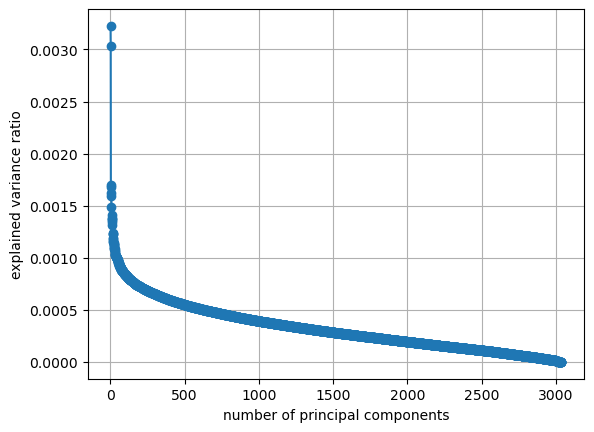

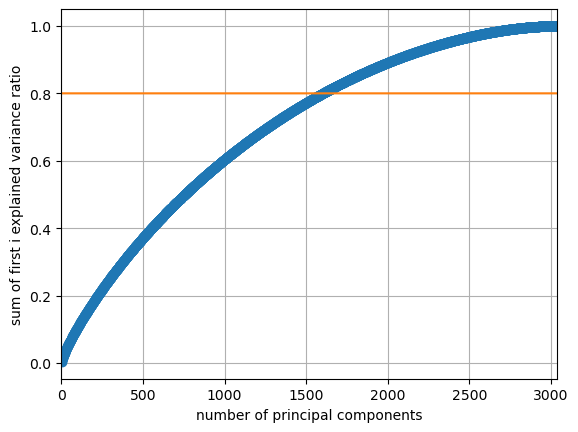

In [6]:
from sklearn.decomposition import PCA

# elbow plot
nc = 3038
pca_elbow = PCA(n_components = nc)
pca_elbow.fit(X_train_s)

variance_ratios = pca_elbow.explained_variance_ratio_

# plot explained variance ratio
plt.plot(range(1,nc+1),variance_ratios, marker = 'o')
plt.xlabel('number of principal components')
plt.ylabel('explained variance ratio')
plt.grid(True)
plt.show()

# plot threshold
plt.plot(range(1,nc+1),variance_ratios.cumsum(), marker = 'o')
plt.plot(range(0,nc+2),[0.8]*(nc+2))
plt.xlim(0,nc+2)
plt.xlabel('number of principal components')
plt.ylabel('sum of first i explained variance ratio')
plt.grid(True)
plt.show()

# apply PCA

In [7]:
from sklearn.decomposition import PCA

n = 1600
pca = PCA(n_components = n)
X_train_pca = pca.fit_transform(X_train_s)
X_test_pca = pca.transform(X_test_s)

# try logistic regression

In [8]:
from sklearn.linear_model import LogisticRegression

# logistic regression without PCA

In [156]:
lgclf = LogisticRegression()
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import balanced_accuracy_score
ovr_lgclf = OneVsRestClassifier(lgclf)
ovr_lgclf = ovr_lgclf.fit(X_train_s, y_train)
y_pred = ovr_lgclf.predict(X_test_s)

ovr_lgclf_train_no_pca = round(ovr_lgclf.score(X_train_s, y_train) * 100, 2)
ovr_lgclf_accuracy_no_pca = round(balanced_accuracy_score(y_test, y_pred) * 100, 2)

print("Training Accuracy    :",ovr_lgclf_train_no_pca)
print("Test Score :",ovr_lgclf_accuracy_no_pca)

/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy    : 100.0
Test Score : 53.06


# logistic regression with PCA

In [155]:
lgclf = LogisticRegression()
ovr_lgclf = OneVsRestClassifier(lgclf)
ovr_lgclf = ovr_lgclf.fit(X_train_pca, y_train)
y_pred = ovr_lgclf.predict(X_test_pca)

ovr_lgclf_train_pca = round(ovr_lgclf.score(X_train_pca, y_train) * 100, 2)
ovr_lgclf_accuracy_pca= round(balanced_accuracy_score(y_test, y_pred) * 100, 2)

print("Training Accuracy    :",ovr_lgclf_train_pca)
print("Test Score :",ovr_lgclf_accuracy_pca)

/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Training Accuracy    : 99.93
Test Score : 49.74


/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# logistic regression with ANOVA

In [86]:
from sklearn.preprocessing import StandardScaler
sc_anova = StandardScaler().fit(X_train_anova)
X_train_anova_s = sc_anova.transform(X_train_anova)
X_test_anova_s = sc_anova.transform(X_test_anova)

In [154]:
lgclf = LogisticRegression()
ovr_lgclf = OneVsRestClassifier(lgclf)
ovr_lgclf = ovr_lgclf.fit(X_train_anova_s, y_train)
y_pred = ovr_lgclf.predict(X_test_anova_s)

lgclf_train_anova = round(ovr_lgclf.score(X_train_anova_s, y_train) * 100, 2)
lgclf_accuracy_anova= round(balanced_accuracy_score(y_test, y_pred) * 100, 2)

print("Training Accuracy    :",lgclf_train_anova)
print("Test Score :",lgclf_accuracy_anova)

/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Training Accuracy    : 95.16
Test Score : 53.37


/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# try perceptron

In [56]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.linear_model import Perceptron

## Perceptron without PCA

In [57]:
np.random.seed(0)

perceptron = Perceptron()
ovr_perceptron = OneVsRestClassifier(perceptron)
ovr_perceptron = ovr_perceptron.fit(X_train_s, y_train)
y_pred = ovr_perceptron.predict(X_test_s)
accuracy = balanced_accuracy_score(y_test, y_pred)

perceptron_train_no_pca = round(ovr_perceptron.score(X_train_s, y_train) * 100, 2)
perceptron_accuracy_no_pca = round(balanced_accuracy_score(y_pred, y_test) * 100, 2)

print("Training Accuracy    :",perceptron_train_no_pca)
print("Test Score :",perceptron_accuracy_no_pca)

Training Accuracy    : 100.0
Test Score : 53.06


## Perceptron with PCA

In [16]:
np.random.seed(0)

perceptron = Perceptron()
ovr_perceptron = OneVsRestClassifier(perceptron)
ovr_perceptron = ovr_perceptron.fit(X_train_pca, y_train)
y_pred = ovr_perceptron.predict(X_test_pca)
accuracy = balanced_accuracy_score(y_test, y_pred)

perceptron_train_pca = round(ovr_perceptron.score(X_train_pca, y_train) * 100, 2)
perceptron_accuracy_pca = round(balanced_accuracy_score(y_pred, y_test) * 100, 2)

print("Training Accuracy    :",perceptron_train_pca)
print("Test Score :",perceptron_accuracy_pca)

Training Accuracy    : 97.24
Test Score : 54.75


# Perceptron with ANOVA

In [88]:
np.random.seed(0)

perceptron = Perceptron()
ovr_perceptron = OneVsRestClassifier(perceptron)
ovr_perceptron = ovr_perceptron.fit(X_train_anova_s, y_train)
y_pred = ovr_perceptron.predict(X_test_anova_s)

perceptron_train_anova = round(ovr_perceptron.score(X_train_anova_s, y_train) * 100, 2)
perceptron_accuracy_anova = round(balanced_accuracy_score(y_pred, y_test) * 100, 2)

print("Training Accuracy    :",perceptron_train_anova)
print("Test Score :",perceptron_accuracy_anova)

Training Accuracy    : 92.86
Test Score : 51.59


# try linear svc

In [14]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

## Linear SVC without PCA

In [15]:
np.random.seed(0)
linear_svc = LinearSVC()
param_grid = {'C': [0.01, 0.1, 1, 10]}
grid = GridSearchCV(linear_svc, param_grid, cv= 5)
grid.fit(X_train_s, y_train)
best_params = grid.best_params_
print(f"The best hyperparameters are {best_params}")

linear_svc_better = LinearSVC(C= best_params['C'])
linear_svc_better = linear_svc_better.fit(X_train_s, y_train)
y_pred = linear_svc_better.predict(X_test_s)

linear_svc_train = round(linear_svc_better.score(X_train_s, y_train) * 100, 2)
linear_svc_accuracy = round(balanced_accuracy_score(y_pred, y_test) * 100, 2)

print("Training Accuracy    :",linear_svc_train)
print("Test Score :",linear_svc_accuracy)

/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1250

The best hyperparameters are {'C': 0.01}


/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Accuracy    : 100.0
Test Score : 51.13


## Linear SVC with PCA

In [17]:
np.random.seed(0)
linear_svc = LinearSVC()
param_grid = {'C': [0.01, 0.1, 1, 10]}
grid = GridSearchCV(linear_svc, param_grid, cv= 5)
grid.fit(X_train_pca, y_train)
best_params = grid.best_params_
print(f"The best hyperparameters are {best_params}")

linear_svc_better = LinearSVC(C= best_params['C'])
linear_svc_better = linear_svc_better.fit(X_train_pca, y_train)
y_pred = linear_svc_better.predict(X_test_pca)

linear_svc_train_pca = round(linear_svc_better.score(X_train_pca, y_train) * 100, 2)
linear_svc_accuracy_pca = round(balanced_accuracy_score(y_pred, y_test) * 100, 2)

print("Training Accuracy    :",linear_svc_train_pca)
print("Test Score :",linear_svc_accuracy_pca)

/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1250

The best hyperparameters are {'C': 0.01}
Training Accuracy    : 100.0
Test Score : 51.13


/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Linear SVC with ANOVA

In [89]:
np.random.seed(0)
linear_svc = LinearSVC()
param_grid = {'C': [0.01, 0.1, 1, 10]}
grid = GridSearchCV(linear_svc, param_grid, cv= 5)
grid.fit(X_train_anova_s, y_train)
best_params = grid.best_params_
print(f"The best hyperparameters are {best_params}")

linear_svc_better = LinearSVC(C= best_params['C'])
linear_svc_better = linear_svc_better.fit(X_train_anova_s, y_train)
y_pred = linear_svc_better.predict(X_test_anova_s)

linear_svc_train_anova = round(linear_svc_better.score(X_train_anova_s, y_train) * 100, 2)
linear_svc_accuracy_anova = round(balanced_accuracy_score(y_pred, y_test) * 100, 2)

print("Training Accuracy    :",linear_svc_train_anova)
print("Test Score :",linear_svc_accuracy_anova)

/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/ziyanhu/a

The best hyperparameters are {'C': 0.01}


/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training Accuracy    : 94.21
Test Score : 53.86


# try kNN

In [66]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score

# kNN without PCA

In [ ]:
# 这一段是以前cv的方法
k_values = np.arange(1, 30, 1)
results = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_s, y_train, cv=5)
    avg_score = scores.mean()
    results.append(avg_score)

best_k = k_values[results.index(max(results))]
print ("Best parameters:", best_k)

Best parameters: 1


In [27]:
from sklearn.neighbors import KNeighborsClassifier
np.random.seed(0)
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 10000, 100)}
grid = GridSearchCV(knn, param_grid, cv= 5)
grid.fit(X_train_s, y_train)
best_params = grid.best_params_
print(f"The best hyperparameters are {best_params}")
best_n_neighbors = best_params['n_neighbors']
knn_better = KNeighborsClassifier(n_neighbors = best_n_neighbors)
knn_better.fit(X_train_s, y_train)
y_pred_knn = knn_better.predict(X_test_s)

knn_train_no_pca = round(knn_better.score(X_train_s, y_train) * 100, 2)
knn_accuracy_no_pca = round(balanced_accuracy_score(y_pred_knn, y_test) * 100, 2)

print("Training Accuracy     :",knn_train_no_pca)
print("Test Score  :",knn_accuracy_no_pca)

/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 706, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/neighbors/_classification.py", line 254, 

The best hyperparameters are {'n_neighbors': 301}
Training Accuracy     : 43.02
Test Score  : 43.03


/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


# kNN with PCA

In [28]:
np.random.seed(0)
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 10000, 100)}
grid = GridSearchCV(knn, param_grid, cv= 5)
grid.fit(X_train_pca, y_train)
best_params = grid.best_params_
print(f"The best hyperparameters are {best_params}")
best_n_neighbors = best_params['n_neighbors']
knn_better = KNeighborsClassifier(n_neighbors = best_n_neighbors)
knn_better.fit(X_train_pca, y_train)
y_pred = knn_better.predict(X_test_pca)

knn_train_pca = round(knn_better.score(X_train_pca, y_train) * 100, 2)
knn_accuracy_pca = round(balanced_accuracy_score(y_pred, y_test) * 100, 2)

print("Training Accuracy     :",knn_train_pca)
print("Test Score  :",knn_accuracy_pca)

/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 706, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/neighbors/_classification.py", line 254, 

The best hyperparameters are {'n_neighbors': 801}
Training Accuracy     : 42.99
Test Score  : 43.03


/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


# kNN with ANOVA

In [90]:
np.random.seed(0)
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 10000, 100)}
grid = GridSearchCV(knn, param_grid, cv= 5)
grid.fit(X_train_anova_s, y_train)
best_params = grid.best_params_
print(f"The best hyperparameters are {best_params}")
best_n_neighbors = best_params['n_neighbors']
knn_better = KNeighborsClassifier(n_neighbors = best_n_neighbors)
knn_better.fit(X_train_anova_s, y_train)
y_pred = knn_better.predict(X_test_anova_s)

knn_train_anova = round(knn_better.score(X_train_anova_s, y_train) * 100, 2)
knn_accuracy_anova = round(balanced_accuracy_score(y_pred, y_test) * 100, 2)

print("Training Accuracy     :",knn_train_anova)
print("Test Score  :",knn_accuracy_anova)

/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 706, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/neighbors/_classification.py", line 254, 

The best hyperparameters are {'n_neighbors': 1}
Training Accuracy     : 99.9
Test Score  : 49.21


# try kernel SVC

In [29]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier

# kernel SVC without PCA

In [30]:
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

# Create the SVM classifier
clf_ovr = SVC(decision_function_shape='ovr')

# Perform grid search with 5-fold cross-validation
grid_search_ovr = GridSearchCV(clf_ovr, param_grid, cv=5, scoring='balanced_accuracy')
grid_search_ovr.fit(X_train_s, y_train)

# Retrieve the best parameters and score
best_params_ovr = grid_search_ovr.best_params_
best_score_ovr = grid_search_ovr.best_score_


print("Best parameters:", best_params_ovr)
print("Best score:", best_score_ovr)

best_svm_ovr = SVC( C=best_params_ovr['C'],kernel=best_params_ovr['kernel'])
best_ovr_classifier = OneVsRestClassifier(best_svm_ovr, n_jobs=-1)
best_ovr_classifier = best_ovr_classifier.fit(X_train_s, y_train)
y_pred_ovr = best_ovr_classifier.predict(X_test_s)

kernel_svc_train_accuracy_no_pca= round(best_ovr_classifier.score(X_train_s, y_train) * 100, 2)
kernel_svc_test_accuracy_no_pca = round(balanced_accuracy_score(y_pred_ovr, y_test) * 100, 2)

print("Training Accuracy     :",kernel_svc_train_accuracy_no_pca)
print("Test Score  :", kernel_svc_test_accuracy_no_pca)

Best parameters: {'C': 0.1, 'kernel': 'linear'}
Best score: 0.5547922652001744
Training Accuracy     : 100.0
Test Score  : 52.44


## kernel SVC with PCA

In [31]:
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

# Create the SVM classifier
clf_ovr = SVC(decision_function_shape='ovr')

# Perform grid search with 5-fold cross-validation
grid_search_ovr = GridSearchCV(clf_ovr, param_grid, cv=5, scoring='balanced_accuracy')
grid_search_ovr.fit(X_train_pca, y_train)

# Retrieve the best parameters and score
best_params_ovr = grid_search_ovr.best_params_
best_score_ovr = grid_search_ovr.best_score_


print("Best parameters:", best_params_ovr)
print("Best score:", best_score_ovr)

best_svm_ovr = SVC( C=best_params_ovr['C'],kernel=best_params_ovr['kernel'])
best_ovr_classifier = OneVsRestClassifier(best_svm_ovr, n_jobs=-1)
best_ovr_classifier = best_ovr_classifier.fit(X_train_pca, y_train)
y_pred = best_ovr_classifier.predict(X_test_pca)

kernel_svc_train_accuracy_pca= round(best_ovr_classifier.score(X_train_pca, y_train) * 100, 2)
kernel_svc_test_accuracy_pca = round(balanced_accuracy_score(y_pred, y_test) * 100, 2)

print("Training Accuracy     :",kernel_svc_train_accuracy_pca)
print("Test Score  :", kernel_svc_test_accuracy_pca)

Best parameters: {'C': 10, 'kernel': 'rbf'}
Best score: 0.5196920756195881
Training Accuracy     : 98.09
Test Score  : 50.19


# kernel SVC with ANOVA

In [91]:
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

# Create the SVM classifier
clf_ovr = SVC(decision_function_shape='ovr')

# Perform grid search with 5-fold cross-validation
grid_search_ovr = GridSearchCV(clf_ovr, param_grid, cv=5, scoring='balanced_accuracy')
grid_search_ovr.fit(X_train_anova_s, y_train)

# Retrieve the best parameters and score
best_params_ovr = grid_search_ovr.best_params_
best_score_ovr = grid_search_ovr.best_score_


print("Best parameters:", best_params_ovr)
print("Best score:", best_score_ovr)

best_svm_ovr = SVC( C=best_params_ovr['C'],kernel=best_params_ovr['kernel'])
best_ovr_classifier = OneVsRestClassifier(best_svm_ovr, n_jobs=-1)
best_ovr_classifier = best_ovr_classifier.fit(X_train_anova_s, y_train)
y_pred = best_ovr_classifier.predict(X_test_anova_s)

kernel_svc_train_accuracy_anova= round(best_ovr_classifier.score(X_train_anova_s, y_train) * 100, 2)
kernel_svc_test_accuracy_anova = round(balanced_accuracy_score(y_pred, y_test) * 100, 2)

print("Training Accuracy     :",kernel_svc_train_accuracy_anova)
print("Test Score  :", kernel_svc_test_accuracy_anova)

Best parameters: {'C': 1, 'kernel': 'rbf'}
Best score: 0.8040103226999188
Training Accuracy     : 91.18
Test Score  : 49.66


# try Decision Tree

In [32]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score

## Decision Tree without PCA

In [33]:
np.random.seed(0)
param_grid = {'ccp_alpha': np.arange(0.001, 0.05, 0.01), 'criterion': ['gini', 'entropy']} 
grid = GridSearchCV(tree.DecisionTreeClassifier(),param_grid=param_grid, cv=5)
grid.fit(X_train_s, y_train)

# Get the best hyperparameters
best_params = grid.best_params_
print (best_params)

{'ccp_alpha': 0.001, 'criterion': 'gini'}


In [34]:
# Train the decision tree classifier with the best hyperparameters
best_decision_tree = tree.DecisionTreeClassifier(ccp_alpha= best_params['ccp_alpha'], criterion= best_params['criterion'])
best_decision_tree.fit(X_train_s, y_train)

Y_pred = best_decision_tree.predict(X_test_s)

decision_train_no_pca = round(best_decision_tree.score(X_train_s, y_train) * 100, 2)
decision_accuracy_no_pca = round(balanced_accuracy_score(Y_pred, y_test) * 100, 2)

print("Training Accuracy     :",decision_train_no_pca)
print("Test Score  :",decision_accuracy_no_pca)

Training Accuracy     : 70.8
Test Score  : 55.1


# Decision Tree with PCA

In [35]:
param_grid = {'ccp_alpha': np.arange(0.001, 0.05,0.001), 'criterion': ['gini', 'entropy']} 
grid = GridSearchCV(tree.DecisionTreeClassifier(),param_grid=param_grid, cv=5)
grid.fit(X_train_pca, y_train)

# Get the best hyperparameters
best_params = grid.best_params_
print (best_params)

{'ccp_alpha': 0.004, 'criterion': 'gini'}


In [36]:
# Train the decision tree classifier with the best hyperparameters
best_decision_tree = tree.DecisionTreeClassifier(ccp_alpha= best_params['ccp_alpha'], criterion= best_params['criterion'])
best_decision_tree.fit(X_train_pca, y_train)

Y_pred = best_decision_tree.predict(X_test_pca)

decision_train_pca = round(best_decision_tree.score(X_train_pca, y_train) * 100, 2)
decision_accuracy_pca = round(balanced_accuracy_score(Y_pred, y_test) * 100, 2)

print("Training Accuracy     :",decision_train_pca)
print("Test Score  :",decision_accuracy_pca)

Training Accuracy     : 49.41
Test Score  : 45.81


# Decision Tree with ANOVA

In [69]:
param_grid = {'ccp_alpha': np.arange(0.001, 0.05,0.001), 'criterion': ['gini', 'entropy']} 
grid = GridSearchCV(tree.DecisionTreeClassifier(),param_grid=param_grid, cv=5)
grid.fit(X_train_anova_s, y_train)

# Get the best hyperparameters
best_params = grid.best_params_
print (best_params)
best_decision_tree = tree.DecisionTreeClassifier(ccp_alpha= best_params['ccp_alpha'], criterion= best_params['criterion'])
best_decision_tree.fit(X_train_anova_s, y_train)

Y_pred = best_decision_tree.predict(X_test_anova_s)

decision_train_anova = round(best_decision_tree.score(X_train_anova_s, y_train) * 100, 2)
decision_accuracy_anova = round(balanced_accuracy_score(Y_pred, y_test) * 100, 2)

print("Training Accuracy     :",decision_train_anova)
print("Test Score  :",decision_accuracy_anova)

{'ccp_alpha': 0.001, 'criterion': 'gini'}
Training Accuracy     : 70.28
Test Score  : 54.96


# Comparing the models

In [157]:
models = pd.DataFrame({
    'Model': [
        'Logistic Regression', 'Perceptron', 'Linear SVC',
          'Kernel SVC',
      'Decision Tree', 'kNN'
       
    ],
    'Training Accuracy without PCA': [
         ovr_lgclf_train_no_pca, 
        perceptron_train_no_pca, 
        linear_svc_train,
        kernel_svc_train_accuracy_no_pca,
        decision_train_no_pca,
        knn_train_no_pca
    ],
    'Training Accuracy with PCA': [
        ovr_lgclf_train_pca, 
        perceptron_train_pca,
        linear_svc_train_pca,
        kernel_svc_train_accuracy_pca,
        decision_train_pca,
        knn_train_pca
    ],
    'Training Accuracy with ANOVA': [
        lgclf_train_anova,
        perceptron_train_anova,
        linear_svc_train_anova,
        kernel_svc_train_accuracy_anova,
        decision_train_anova,
        knn_train_anova
    ],
    'Test Score without PCA': [
        ovr_lgclf_accuracy_no_pca,
        perceptron_accuracy_no_pca, 
        linear_svc_accuracy,
        kernel_svc_test_accuracy_no_pca,
        decision_accuracy_no_pca,
        knn_accuracy_no_pca
    ],
    'Test Score with PCA':[
        ovr_lgclf_accuracy_pca,
        perceptron_accuracy_pca,
        linear_svc_accuracy_pca,
        kernel_svc_test_accuracy_pca,
        decision_accuracy_pca,
        knn_accuracy_pca
    ],
    'Test Score with ANOVA':[
        lgclf_accuracy_anova,
        perceptron_accuracy_anova,
        linear_svc_accuracy_anova,
        kernel_svc_test_accuracy_anova,
        decision_accuracy_anova,
        knn_accuracy_anova
    ]
})

In [158]:
models.sort_values(by='Test Score with ANOVA', ascending=False).style.background_gradient(
        cmap='coolwarm').hide().set_properties(**{
            'font-family': 'Lucida Calligraphy',
            'color': 'LigntGreen',
            'font-size': '15px'
        })

# Try RNN

In [75]:
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers
from sklearn.preprocessing import LabelEncoder

In [76]:
sentences = []
labels = []

for index, row in data.iterrows():
    sentences.append(row['cleaned_text'])
    labels.append(row['Sentiment'])

encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

vocab_size = 10000
embedding_dim = 16
max_length = 200
oov_tok = ''
training_size = 2000

training_sentences = sentences[0:training_size]
test_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [77]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token="")
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

In [79]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length)
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length) 

print(training_padded.shape)
print(test_padded.shape)
print(training_sentences[0])
print(training_padded[0])
print(training_padded[0].shape)

(2000, 200)
(1798, 200)
TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up  
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0  

In [94]:
keras.utils.set_random_seed(2023)

# try simple RNN

In [149]:
num_classes = 3

model = Sequential()
# Specify the input layer with 120 input
model.add(layers.InputLayer(input_shape=(max_length,)))
# to build an embedding matrix with 10000 rows and 16 columns and
# every row (with 16 numbers) of the marrix represents the feature vector of a unique word
model.add(layers.Embedding(vocab_size, embedding_dim))
# add a vanilla recurrent layer with units = 32
model.add(tf.keras.layers.SimpleRNN(units = 32))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 200, 16)           160000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                1568      
                                                                 
 dense_12 (Dense)            (None, 10)                330       
                                                                 
 dense_13 (Dense)            (None, 3)                 33        
                                                                 
Total params: 161,931
Trainable params: 161,931
Non-trainable params: 0
_________________________________________________________________


In [96]:
#Callback function

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [150]:
training_labels_final = np.array(training_labels)
test_labels_final = np.array(testing_labels)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs=30
history=model.fit(training_padded, 
                  training_labels_final, 
                  epochs=epochs, 
                  validation_data=(test_padded, test_labels_final))

Epoch 1/30
63/63 [==============================] - 1s 15ms/step - loss: 1.0608 - accuracy: 0.4095 - val_loss: 1.0290 - val_accuracy: 0.4210
Epoch 2/30
63/63 [==============================] - 1s 14ms/step - loss: 0.9894 - accuracy: 0.5205 - val_loss: 1.0333 - val_accuracy: 0.4143
Epoch 3/30
63/63 [==============================] - 1s 15ms/step - loss: 0.7977 - accuracy: 0.7075 - val_loss: 1.0478 - val_accuracy: 0.4522
Epoch 4/30
63/63 [==============================] - 1s 15ms/step - loss: 0.4058 - accuracy: 0.8800 - val_loss: 1.2231 - val_accuracy: 0.4405
Epoch 5/30
63/63 [==============================] - 1s 16ms/step - loss: 0.1644 - accuracy: 0.9680 - val_loss: 1.4682 - val_accuracy: 0.4494
Epoch 6/30
63/63 [==============================] - 1s 20ms/step - loss: 0.0604 - accuracy: 0.9905 - val_loss: 1.6333 - val_accuracy: 0.4410
Epoch 7/30
63/63 [==============================] - 1s 15ms/step - loss: 0.0218 - accuracy: 0.9985 - val_loss: 1.8221 - val_accuracy: 0.4366
Epoch 8/30
63

In [146]:
# Get the accuracy of test data set
test_loss, test_accuracy = model.evaluate(test_padded, test_labels_final)
print('Accuracy: ', test_accuracy, '\nTest Loss: ', test_loss)

57/57 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.3293
Accuracy:  0.32925471663475037 
Test Loss:  0.0


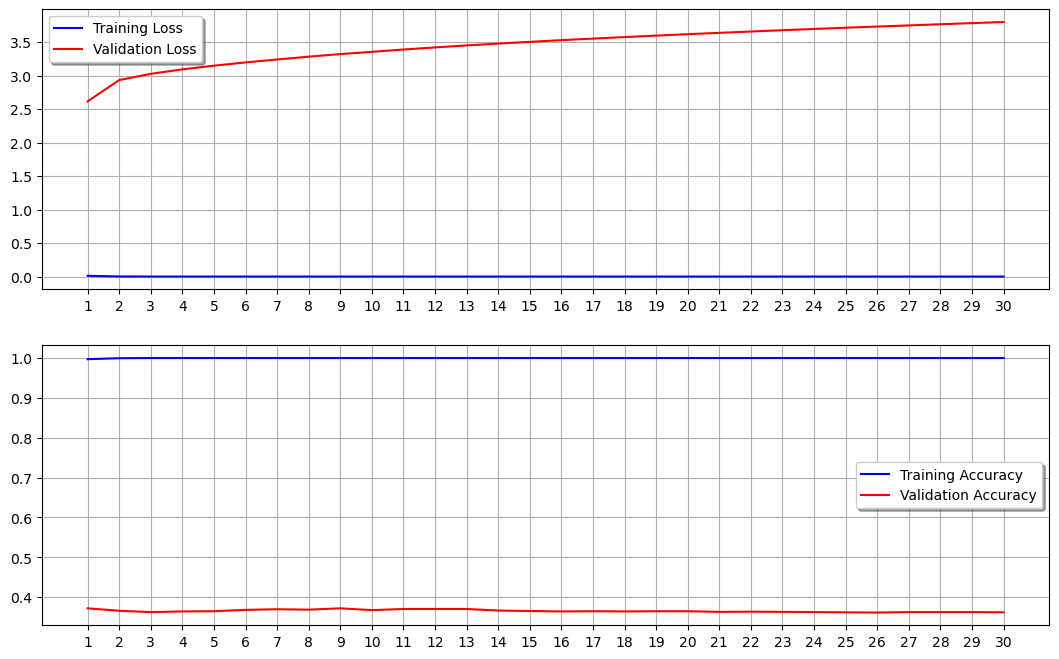

In [102]:
run_epochs = 30

fig, ax = plt.subplots(2, 1, figsize=(13, 8))
plt.setp(ax, xticks=list(range(1, run_epochs+1)))

ax[0].plot(list(range(1, run_epochs+1)), history.history['loss'], color='b', label="Training Loss")
ax[0].plot(list(range(1, run_epochs+1)), history.history['val_loss'], color='r', label="Validation Loss")
legend = ax[0].legend(loc='best', shadow=True)
ax[0].grid()

ax[1].plot(list(range(1, run_epochs+1)), history.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(list(range(1, run_epochs+1)), history.history['val_accuracy'], color='r', label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)
ax[1].grid()

plt.show()

In [139]:
num_classes = 3
from keras.layers import InputLayer, Embedding, LSTM, Dense, GRU

model = Sequential() 
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(tf.keras.layers.LSTM(units = 32))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'])

history=model.fit(training_padded, 
                  training_labels_final, 
                  epochs=epochs, 
                  validation_split=0.1,
                  validation_data = (test_padded, test_labels_final)
                  )

Epoch 1/30


2023-12-15 21:27:50.979486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-15 21:27:50.980291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-15 21:27:50.980696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

61/63 [============================>.] - ETA: 0s - loss: 0.2476 - accuracy: 0.1568

2023-12-15 21:27:53.572205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-15 21:27:53.572881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-15 21:27:53.573356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

63/63 [==============================] - 3s 35ms/step - loss: 0.2494 - accuracy: 0.1600 - val_loss: 0.0488 - val_accuracy: 0.1663
Epoch 2/30
63/63 [==============================] - 2s 36ms/step - loss: 0.1543 - accuracy: 0.1600 - val_loss: 0.0263 - val_accuracy: 0.1663
Epoch 3/30
63/63 [==============================] - 2s 31ms/step - loss: -0.0984 - accuracy: 0.1610 - val_loss: -0.3758 - val_accuracy: 0.1696
Epoch 4/30
63/63 [==============================] - 2s 30ms/step - loss: -0.6659 - accuracy: 0.2030 - val_loss: -1.1831 - val_accuracy: 0.2047
Epoch 5/30
63/63 [==============================] - 2s 30ms/step - loss: -2.3400 - accuracy: 0.2675 - val_loss: -2.4620 - val_accuracy: 0.2102
Epoch 6/30
63/63 [==============================] - 2s 30ms/step - loss: -2.6215 - accuracy: 0.2475 - val_loss: -3.2178 - val_accuracy: 0.2180
Epoch 7/30
63/63 [==============================] - 2s 30ms/step - loss: -7.1050 - accuracy: 0.3595 - val_loss: -5.3266 - val_accuracy: 0.2575
Epoch 8/30
63/

In [140]:
# Get the accuracy of test data set
test_loss_lstm, test_accuracy_lstm = model.evaluate(test_padded, test_labels_final)
print('Accuracy: ', test_accuracy_lstm, '\nTest Loss: ', test_loss_lstm)

57/57 [==============================] - 0s 8ms/step - loss: -110.9654 - accuracy: 0.3053
Accuracy:  0.3053392767906189 
Test Loss:  -110.96544647216797


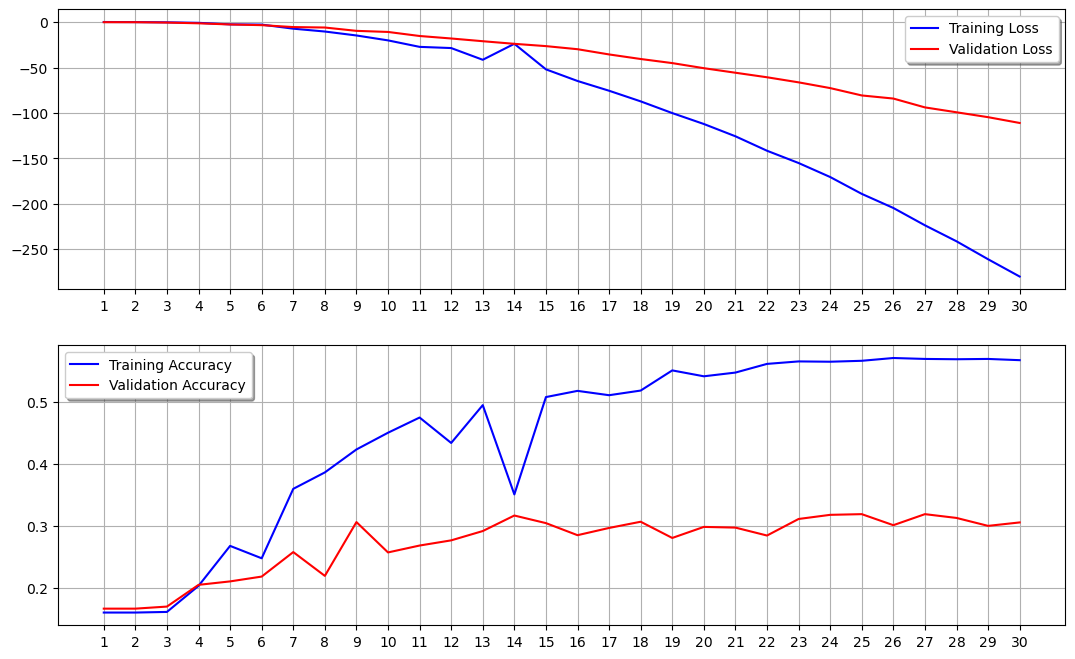

In [141]:
run_epochs = 30

fig, ax = plt.subplots(2, 1, figsize=(13, 8))
plt.setp(ax, xticks=list(range(1, run_epochs+1)))

ax[0].plot(list(range(1, run_epochs+1)), history.history['loss'], color='b', label="Training Loss")
ax[0].plot(list(range(1, run_epochs+1)), history.history['val_loss'], color='r', label="Validation Loss")
legend = ax[0].legend(loc='best', shadow=True)
ax[0].grid()

ax[1].plot(list(range(1, run_epochs+1)), history.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(list(range(1, run_epochs+1)), history.history['val_accuracy'], color='r', label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)
ax[1].grid()

plt.show()

In [132]:
# add the GRU layer to tune the model
model = Sequential() 
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(tf.keras.layers.GRU(units = 32))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['acc'])

history_gru=model.fit(training_padded, 
                  training_labels_final, 
                  epochs=epochs, 
                  validation_split=0.1,
                  validation_data = (test_padded, test_labels_final)
                  )

Epoch 1/30


2023-12-15 21:22:05.267678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-15 21:22:05.268477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-15 21:22:05.268926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

63/63 [==============================] - ETA: 0s - loss: 0.3100 - acc: 0.1615

2023-12-15 21:22:09.102455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-15 21:22:09.103206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-15 21:22:09.103734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

63/63 [==============================] - 4s 35ms/step - loss: 0.3100 - acc: 0.1615 - val_loss: 0.0264 - val_acc: 0.1663
Epoch 2/30
63/63 [==============================] - 2s 32ms/step - loss: 0.0686 - acc: 0.1600 - val_loss: -0.1141 - val_acc: 0.1663
Epoch 3/30
63/63 [==============================] - 2s 38ms/step - loss: -0.5997 - acc: 0.1725 - val_loss: -0.8591 - val_acc: 0.1991
Epoch 4/30
63/63 [==============================] - 2s 33ms/step - loss: -2.2070 - acc: 0.2855 - val_loss: -1.2349 - val_acc: 0.2887
Epoch 5/30
63/63 [==============================] - 2s 31ms/step - loss: -4.3856 - acc: 0.3595 - val_loss: -2.6849 - val_acc: 0.2430
Epoch 6/30
63/63 [==============================] - 2s 31ms/step - loss: -7.3077 - acc: 0.4205 - val_loss: -3.8427 - val_acc: 0.3081
Epoch 7/30
63/63 [==============================] - 2s 31ms/step - loss: -10.8796 - acc: 0.4305 - val_loss: -5.7458 - val_acc: 0.2948
Epoch 8/30
63/63 [==============================] - 2s 31ms/step - loss: -14.5998 

In [133]:
test_loss_gru, test_accuracy_gru = model.evaluate(test_padded, test_labels_final)
print('Accuracy: ', test_accuracy_gru, '\nTest Loss: ', test_loss_gru)

57/57 [==============================] - 0s 5ms/step - loss: -61.7226 - acc: 0.3443
Accuracy:  0.3442714214324951 
Test Loss:  -61.72262191772461


In [ ]:
fig, ax = plt.subplots(2,1, figsize=(18,8))
plt.setp(ax, xticks=list(range(1,epochs+1)))

ax[0].plot(list(range(1,epochs+1)),history_lstm.history['loss'], color='b', label="Training Loss")
ax[0].plot(list(range(1,epochs+1)),history_lstm.history['val_loss'], color='r', label="Validation Loss")
legend = ax[0].legend(loc='best', shadow=True)
ax[0].grid()

ax[1].plot(list(range(1,epochs+1)),history_lstm.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(list(range(1,epochs+1)),history_lstm.history['val_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)
ax[1].grid()

# try clustering

In [103]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import rand_score

In [106]:
from sklearn.decomposition import PCA

#stfidf vectorization
tfidf_vectorizer_all = TfidfVectorizer(stop_words='english') 
X_all = tfidf_vectorizer_all.fit_transform(text_list)
vocabulary_all = tfidf_vectorizer_all.vocabulary_

#standardization + pca
X_array = X_all.toarray()
X_s = sc.fit_transform(X_array)

n = 1600
pca = PCA(n_components = n)
X_pca = pca.fit_transform(X_s)

#ANOVA + standardization
y = category_encoded

f_classif(X_all, y)
X_all_tran = X_all.astype(np.float32)
k=min(125, X_all_tran.shape[1])
selector_all = SelectKBest(f_classif, k=k).fit(X_all_tran, y)
X_anova = selector_all.transform(X_all_tran)
print(X_anova.shape)
                       
# already fitted the SelectKBest instance and transformed the data
selected_mask_all = selector_all.get_support()

# Filter the feature names based on the selected mask
selected_features_all = [feature for feature, selected in zip(vocabulary_all, selected_mask_all) if selected]

# Print the selected features and their corresponding keywords
number = 0
for feature in selected_features_all:
    number = number+1
    print(number, feature)
    
X_anova_array = X_anova.toarray()
X_anova_s = sc.fit_transform(X_anova_array)

(3798, 125)
1 living
2 night
3 purchases
4 hired
5 stimulus
6 weeks
7 bolstering
8 bcseniors
9 players
10 transmittable
11 rice
12 discover
13 role
14 shuttered
15 life
16 focus
17 stockphotography
18 rockville
19 thought
20 terribly
21 flashbacks
22 lockdown
23 eos
24 domestic
25 push
26 butts
27 panika
28 dnes
29 duped
30 experiencing
31 cancel2020
32 crazyness
33 thursdayvibes
34 unusually
35 eviction
36 topics
37 vision
38 wherethesoap
39 bali
40 ghana
41 marketers
42 indians
43 satisfied
44 poo
45 halts
46 trumpcrash
47 handwashing
48 minimise
49 wanker
50 covid19be
51 agreement
52 drilling
53 aspects
54 burning
55 timing
56 aussie
57 loom
58 queens
59 beverages
60 essenced
61 documentary
62 iowa
63 realises
64 insightful
65 suck
66 inducing
67 sherway
68 extortionate
69 hunting
70 napkins
71 competitiveness
72 exact
73 letter
74 firefighter
75 subscribe
76 newest
77 lamps
78 2nd
79 qatarliving
80 banning
81 mankind
82 nasty
83 interestingpriorities
84 intrepid
85 badkarma
86 loop

/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will chang

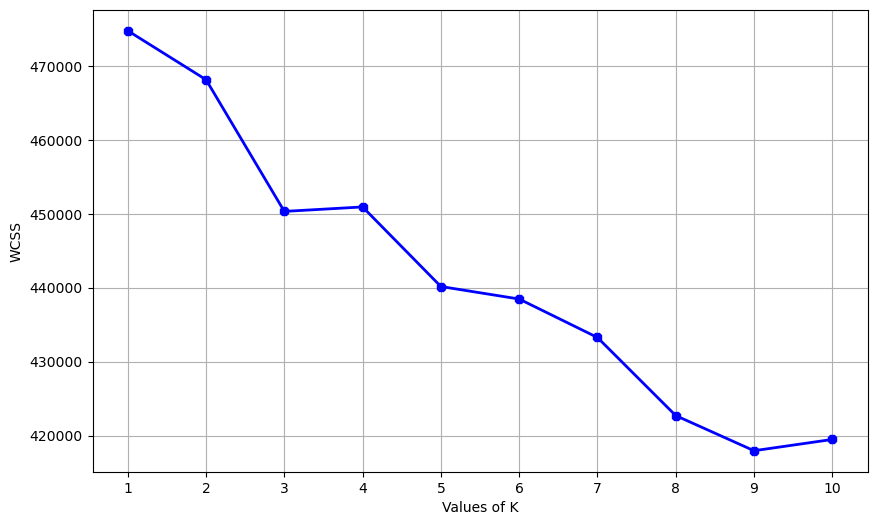

In [107]:
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_anova_s)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(10,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="blue", marker ="8")
plt.xlabel("Values of K")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

# try k=3

In [108]:
K = 3

kmeans = KMeans(n_clusters=K, init='random', random_state=123)
kmeans.fit(X_anova_s)

y_kmeans = kmeans.predict(X_anova_s)
rand_index = rand_score(y,y_kmeans)
print(rand_index)

0.4659523753058559


/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [117]:
# Count the number of data points in each cluster
cluster_counts = {}
for label in y_kmeans:
    if label in cluster_counts:
        cluster_counts[label] += 1
    else:
        cluster_counts[label] = 1

# Print the number of data points in each cluster
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} data points")

Cluster 0: 2963 data points
Cluster 1: 787 data points
Cluster 2: 48 data points


In [118]:
# Get the centroids of each cluster
centroids = kmeans.cluster_centers_

# Print the centroids
for i, centroid in enumerate(centroids):
    print(f"Centroid {i+1}: {centroid}")
    
origin_text_list = data['cleaned_text'].fillna('').tolist()

# Find the original texts corresponding to each centroid
centroid_texts = []
for centroid in centroids:
    centroid_index = np.argmin(np.linalg.norm(X_anova_s - centroid, axis=1))
    centroid_text = origin_text_list[centroid_index]
    centroid_texts.append(centroid_text)

# Print the original texts corresponding to each centroid
for i, centroid_text in enumerate(centroid_texts):
    print(f"Centroid {i+1}: {centroid_text}")

Centroid 1: [ 1.51402727e-02  1.58194508e-02  1.58194508e-02  1.40005220e-02
 -2.20822748e-02  4.22798470e-03 -5.76642063e-03 -2.41459627e-02
 -2.72143586e-03  1.01419631e-02  1.64463688e-02  2.17128522e-03
 -2.15898994e-02  1.50394002e-02  3.72425281e-03 -4.23889421e-02
 -6.68508280e-03 -2.73656379e-02  1.01405252e-02  1.10302903e-02
 -5.88181568e-03 -1.74430870e-02 -1.82047486e-02 -1.45852447e-01
  1.00919921e-02 -1.20938392e-02 -2.35568043e-02  7.19443895e-03
  5.16754128e-02  2.03575753e-02  2.76695490e-02  1.80750005e-02
  1.34357372e-02 -4.00870893e-04  3.28429672e-03  1.91492382e-02
  1.17927447e-01  3.32081430e-02 -7.82071427e-03 -4.52113990e-03
 -2.92717405e-02 -1.10655921e-02  4.79361787e-03 -4.07629788e-01
  7.81302992e-03  1.31080253e-02  2.06192248e-02 -9.03119892e-03
  1.51996901e-02  1.30027579e-02  2.38639452e-02  2.28470434e-02
  2.91921031e-02  2.31899489e-02  3.00185499e-03  8.95333942e-03
 -2.81161722e-02  1.70407724e-02 -8.74687452e-03 -4.15441543e-02
 -3.06116249e

# try WordCloud (k=3)

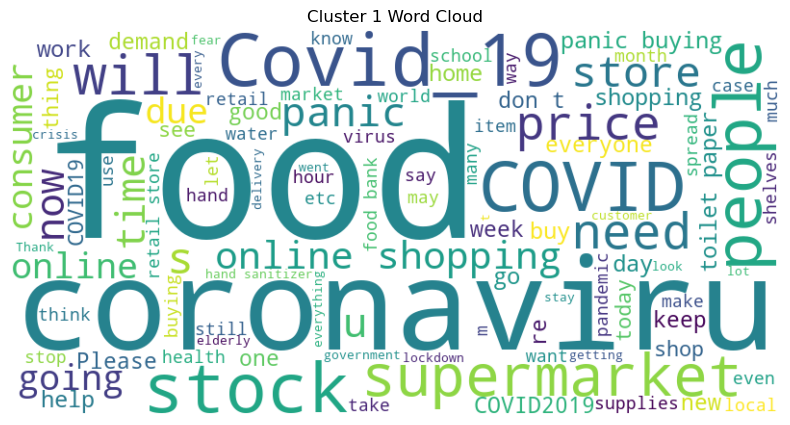

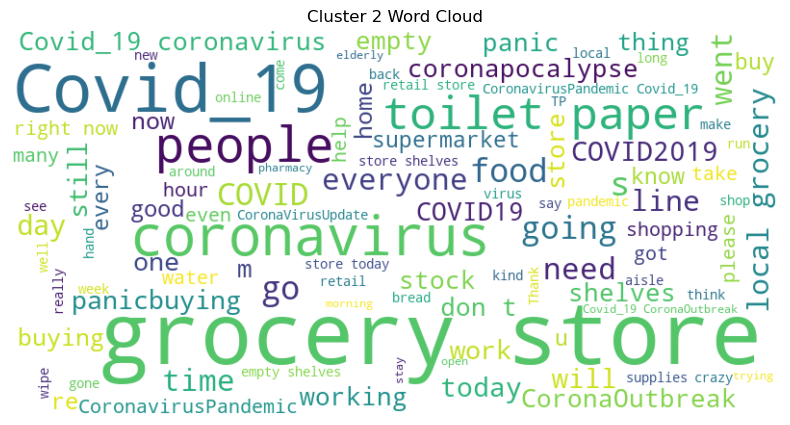

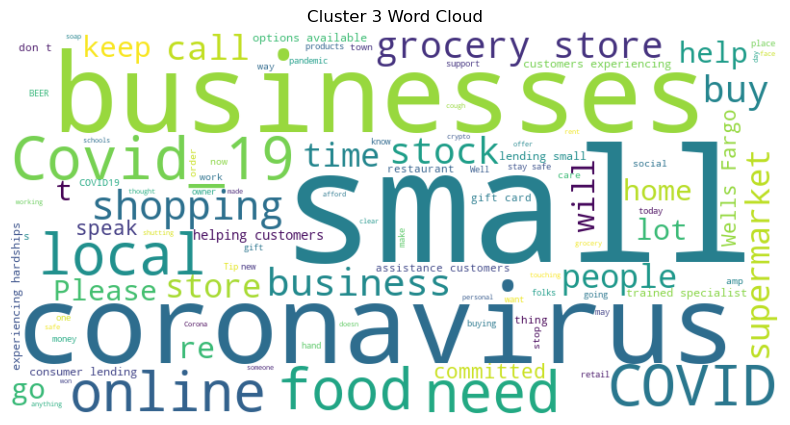

In [119]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
cluster_texts = [[] for _ in range(K)]  # Initialize a list for each cluster

for i, cluster_label in enumerate(y_kmeans):
    original_text = text_list[i]  # Assuming `text_list` contains the original texts
    cluster_texts[cluster_label].append(original_text)
    
for cluster_label, cluster_text in enumerate(cluster_texts):
    # Combine all texts in the cluster into a single string
    cluster_text_combined = ' '.join(cluster_text)

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(cluster_text_combined)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Cluster {cluster_label + 1} Word Cloud")
    plt.axis('off')
    plt.show()

# try k=9 (the elbow point)

In [120]:
K = 9

kmeans = KMeans(n_clusters=K, init='random', random_state=123)
kmeans.fit(X_anova_s)

y_kmeans = kmeans.predict(X_anova_s)
# Count the number of data points in each cluster
cluster_counts = {}
for label in y_kmeans:
    if label in cluster_counts:
        cluster_counts[label] += 1
    else:
        cluster_counts[label] = 1

# Print the number of data points in each cluster
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} data points")

Cluster 3: 486 data points
Cluster 4: 2663 data points
Cluster 1: 39 data points
Cluster 7: 71 data points
Cluster 5: 30 data points
Cluster 6: 411 data points
Cluster 8: 53 data points
Cluster 0: 33 data points
Cluster 2: 12 data points


/Users/ziyanhu/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [121]:
# Get the centroids of each cluster
centroids = kmeans.cluster_centers_

# Print the centroids
for i, centroid in enumerate(centroids):
    print(f"Centroid {i+1}: {centroid}")

Centroid 1: [-0.05372601 -0.05613505 -0.05613505 -0.06623925 -0.0759442   0.3172829
 -0.09291962 -0.10981791  0.46328375 -0.0359881   1.2426394  -0.12546158
 -0.10456987 -0.20008798  0.8143958  -0.06658083  0.21674149 -0.06365845
  0.28333727 -0.03914077  0.38743895 -0.02801793 -0.05029934 -0.52099836
  0.0585827   0.23430622 -0.05378982 -0.05395877 -0.05112839 -0.07223892
  0.18167026  0.3746186   1.0985613  -0.05665732 -0.10664245 -0.0788103
  0.2622007   0.64461505  0.61247325 -0.08463506 -0.05465122 -0.16296956
 -0.10826099 -0.36659637 -0.1791233   0.7789974  10.367614   -0.0688633
  0.2621042   0.14036292 -0.10220571  0.14684337  0.18426503 -0.08228941
 -0.03500813 -0.03177193 -0.02811608 -0.14877097 -0.11720149 -0.18018822
 -0.03557262 -0.06362075 -0.0793695   0.11877268 -0.0521872  -0.02790626
 -0.04470207 -0.04479914  0.18265443 -0.02811608 -0.10869224  0.13558672
 -0.17097512 -0.08870618 -0.13318606 -0.06814779 -0.07445084 -0.04113017
  0.24799922 -0.06944218  0.2343263   0.23

In [122]:
origin_text_list = data['cleaned_text'].fillna('').tolist()

# Find the original texts corresponding to each centroid
centroid_texts = []
for centroid in centroids:
    centroid_index = np.argmin(np.linalg.norm(X_anova_s - centroid, axis=1))
    centroid_text = origin_text_list[centroid_index]
    centroid_texts.append(centroid_text)

# Print the original texts corresponding to each centroid
for i, centroid_text in enumerate(centroid_texts):
    print(f"Centroid {i+1}: {centroid_text}")

Centroid 1: Worried about coronavirus? You want to stock your pantry? Check out this guide about healthy #non_perishable_food. 
#CoronavirusPandemic #Covid_19 #non_perishable_foods_list #survival_food
#non_perishables #non_expiring_food #emergency_food

 
Centroid 2: Alright y?all I hope our Melanin prevails but just in case I took some precautions I had some food & water delivered. ????? I?ve had my masks for a month and may have to open soon! 
?? #B1 #FBA 

#CoronavirusUSA #COVID 
Centroid 3: Call your Senators. Demand they pass the #FamiliesFirst #coronavirus bill containing:

-Free testing
-14 days paid sick leave
-3 months paid family leave
-Expanded unemployment insurance -Food security
-Medicaid funds 

Ask for your senator?s office. (202) 224-3121 #COVID19
Centroid 4: First time in 2 weeks that I have seen loo roll in a supermarket! So I bought a sensible quantity of 12! #CalamityCorona #Covid_19 #ToiletPaperApocalypse #stoppanicking
Centroid 5: Stock up on Food & Water asap be

# try WordCloud (k=9)

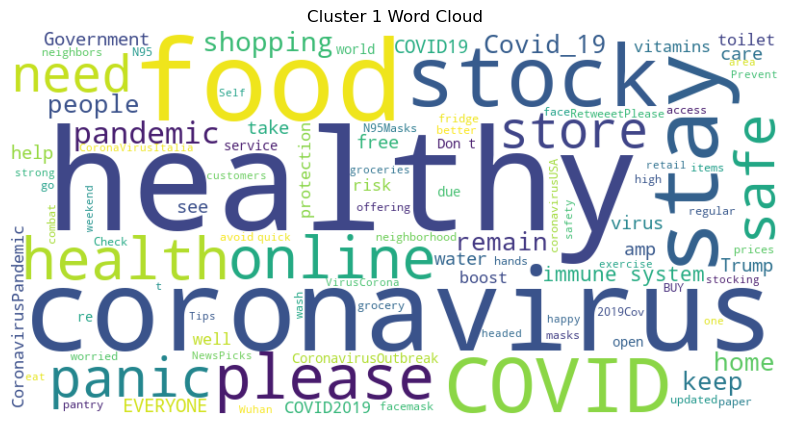

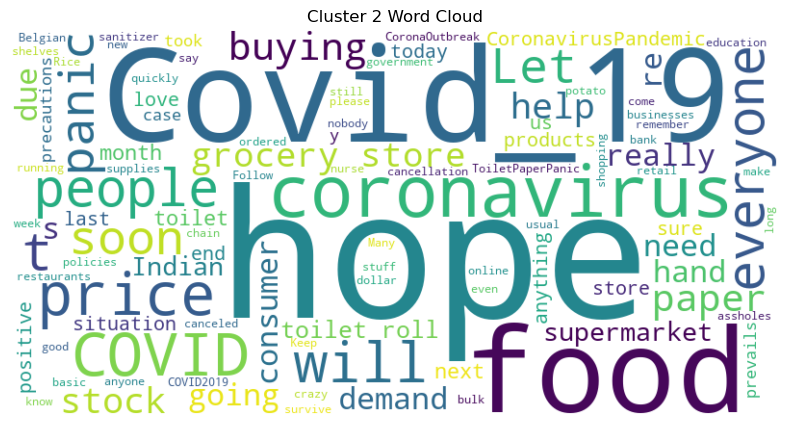

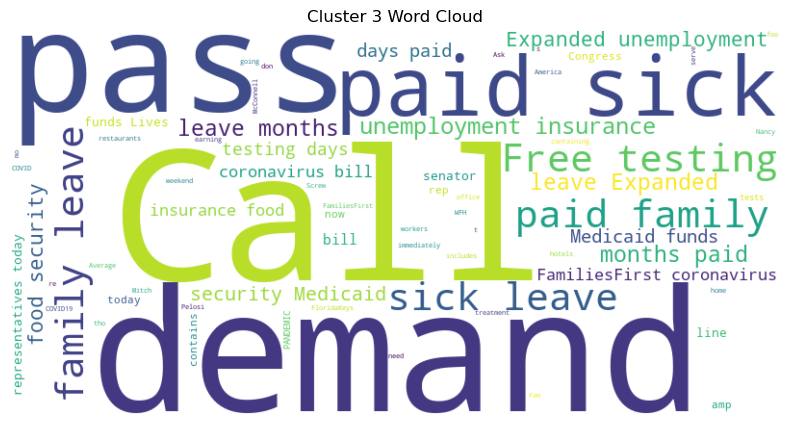

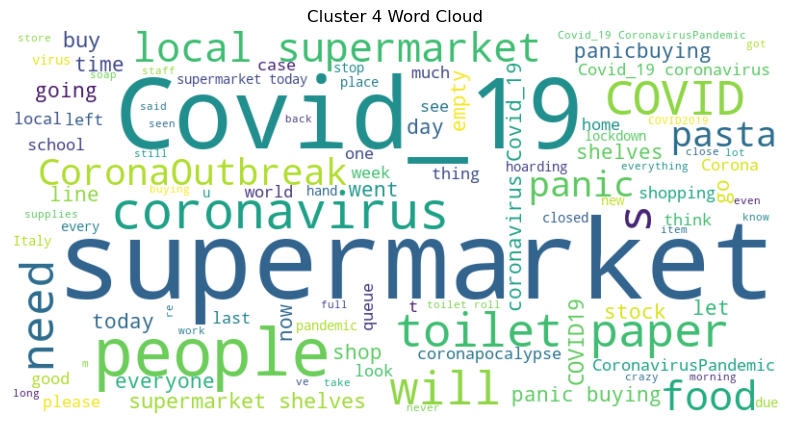

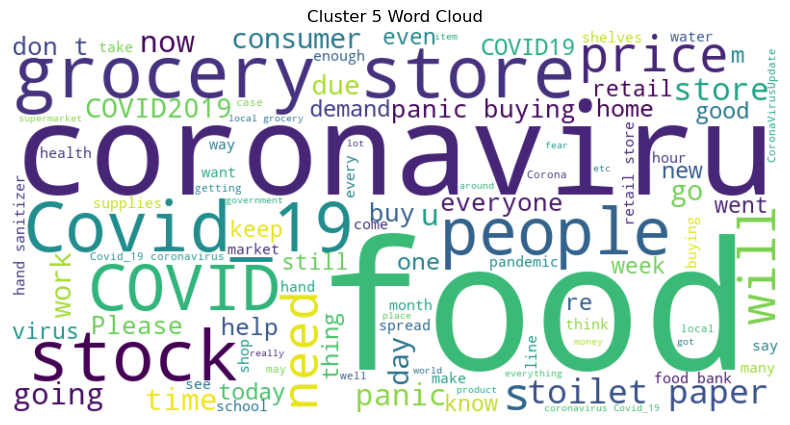

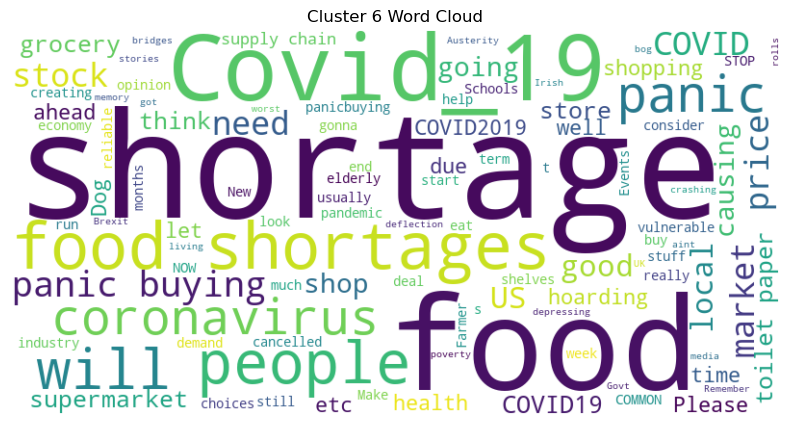

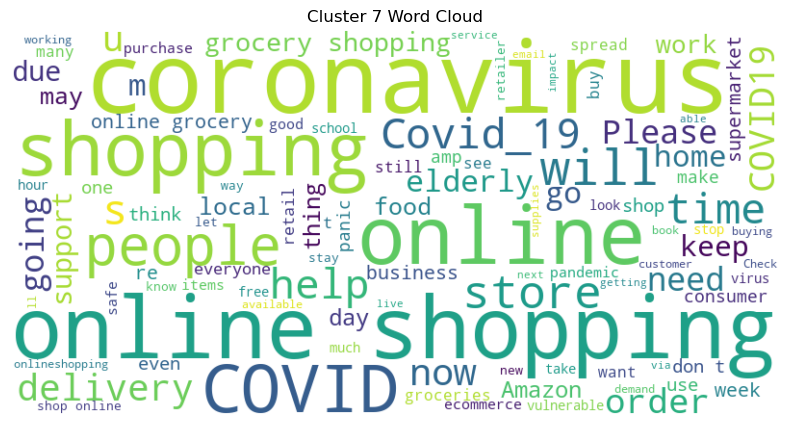

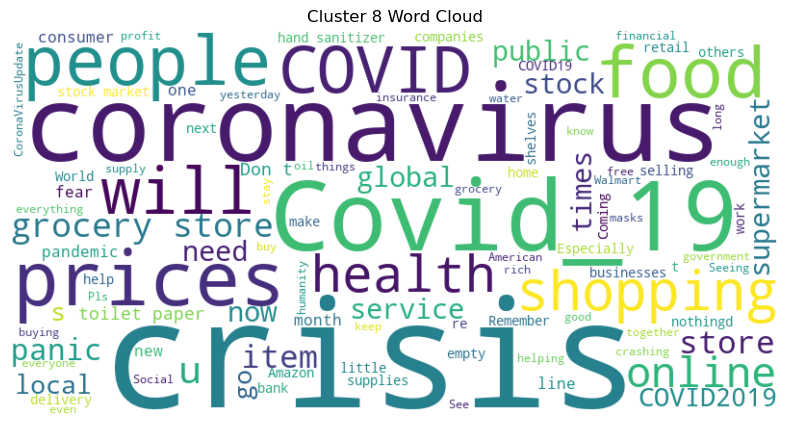

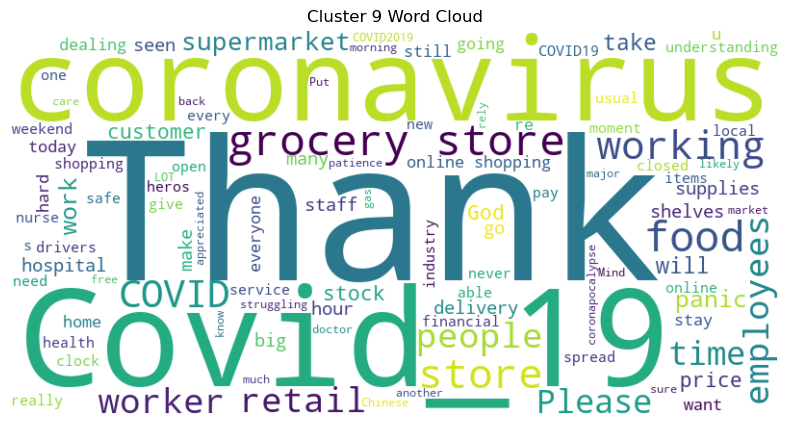

In [123]:
cluster_texts = [[] for _ in range(K)]  # Initialize a list for each cluster

for i, cluster_label in enumerate(y_kmeans):
    original_text = text_list[i]  # Assuming `text_list` contains the original texts
    cluster_texts[cluster_label].append(original_text)
    
for cluster_label, cluster_text in enumerate(cluster_texts):
    # Combine all texts in the cluster into a single string
    cluster_text_combined = ' '.join(cluster_text)

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(cluster_text_combined)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Cluster {cluster_label + 1} Word Cloud")
    plt.axis('off')
    plt.show()